In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


**FUNCIONS DE L'APP**

In [3]:
def carregar_dades(ciutat):
    # Població
    df_poblacio = pd.read_csv(f'dat/{ciutat}/poblacio.csv', skiprows=10, sep=";", decimal=",")
    df_poblacio.rename(columns={"Unnamed: 0":"Any", "Total":"Població"}, inplace=True)
    df_poblacio = df_poblacio.set_index("Any")
    df_poblacio = df_poblacio[['Població']]
    
    # Densitat
    df_densitat = pd.read_csv(f'dat/{ciutat}/densitat.csv', skiprows=6, sep=";", decimal=',')
    df_densitat.rename(columns={"Unnamed: 0":"Any", "Superfície (km²)":"Superfície", "Densitat (hab./km²)":"Densitat"}, inplace=True)
    df_densitat.set_index("Any", inplace=True)
    df_densitat = df_densitat[['Superfície', 'Densitat']]
    
    # Naixements
    df_naixements = pd.read_csv(f'dat/{ciutat}/naixements.csv', skiprows=8, sep=";")
    df_naixements.rename(columns={"Unnamed: 0":"Any", "Total":"Naixements"}, inplace=True)
    df_naixements.set_index("Any", inplace=True)
    df_naixements = df_naixements[['Naixements']]
    
    # Defuncions
    df_defuncions = pd.read_csv(f'dat/{ciutat}/defuncions.csv', skiprows=7, sep=";")
    df_defuncions.rename(columns={"Unnamed: 0":"Any", "Total":"Defuncions"}, inplace=True)
    df_defuncions.set_index("Any", inplace=True)
    df_defuncions = df_defuncions[['Defuncions']]

    # Aturats
    df_atur = pd.read_csv(f'dat/{ciutat}/atur.csv', skiprows=6, sep=";", decimal=',')
    df_atur.rename(columns={"Unnamed: 0":"Any", "Sexe. Total":"Aturats"}, inplace=True)
    df_atur = df_atur.set_index("Any")
    df_atur = df_atur[['Aturats']]

    # Pensionistes
    df_pensionistes = pd.read_csv(f'dat/{ciutat}/pensionistes.csv', skiprows=7, sep=";")
    df_pensionistes.rename(columns={'Unnamed: 0':'Any', 'Total':'Pensionistes'}, inplace=True)
    df_pensionistes = df_pensionistes.set_index("Any")
    df_pensionistes = df_pensionistes[['Pensionistes']]

    # Habitatges acabats
    df_habit = pd.read_csv(f'dat/{ciutat}/habitatges_construits.csv', skiprows=10, sep=";")
    noves_col = {
        'Unnamed: 0':'Any',
        'Habitatges iniciats amb protecció oficial':'HPO iniciats',
        'Habitatges acabats amb protecció oficial':'HPO acabats'
    }
    df_habit.rename(columns=noves_col, inplace=True)
    df_habit.set_index('Any', inplace=True)
    df_habit = df_habit[['HPO acabats', 'Habitatges acabats']]

    # Vehicles
    df_vehicles = pd.read_csv(f'dat/{ciutat}/vehicles.csv', skiprows=6, sep=";")
    df_vehicles.rename(columns={'Unnamed: 0':'Any'}, inplace=True)
    df_vehicles.set_index('Any', inplace=True)
    df_vehicles = df_vehicles[['Turismes', 'Motocicletes']]

    # Renta Familiar Disponible per Habitant
    df_rdf = pd.read_csv(f'dat/{ciutat}/rfd.csv', skiprows=6, sep=";")
    df_rdf.rename(columns={"Unnamed: 0":"Any",'Per habitant (€)':'RFDH' }, inplace=True)
    df_rdf = df_rdf.set_index("Any")
    df_rdf = df_rdf[['RFDH']]

    # Saldo de migracions internes
    df_migracionsint = pd.read_csv(f'dat/{ciutat}/migracions_internes.csv', skiprows=7, sep=";", decimal=",")
    df_migracionsint.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions internes'}, inplace=True)
    df_migracionsint = df_migracionsint.set_index("Any")
    df_migracionsint = df_migracionsint[['Migracions internes']]

    # Saldo de migracions externes
    df_migracionsext = pd.read_csv(f'dat/{ciutat}/migracions_externes.csv', skiprows=8, sep=";", decimal=",")
    df_migracionsext.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions externes'}, inplace=True)
    df_migracionsext = df_migracionsext.set_index("Any")
    df_migracionsext = df_migracionsext[['Migracions externes']]
    
    df = pd.concat([df_poblacio, df_densitat, df_naixements, df_defuncions, df_migracionsint, df_migracionsext,
                    df_atur, df_pensionistes, df_habit, df_vehicles, df_rdf], axis=1).sort_index(ascending=True)
    
    return df

def neteja_dades (df):
    df = df.drop(range(1975,2010))
    df.drop(2025, inplace=True)
    df['Població'] = df['Població'].fillna(round(df['Densitat']* df['Superfície'], 0)) # Omplim els NAN amb Densitat * Superfície
    df.loc[2015, 'Pensionistes'] = round((df['Pensionistes'][2016]+df['Pensionistes'][2014])/2, 0) # Omplim els NAN amb una interpolació lineal
    df.loc[2010, 'Pensionistes'] = round(2 * df.loc[2011, 'Pensionistes'] - df.loc[2012, 'Pensionistes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2023, 'RFDH'] = round(2 * df.loc[2022, 'RFDH'] - df.loc[2021, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'RFDH'] = round(2 * df.loc[2023, 'RFDH'] - df.loc[2022, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions internes'] = round(2 * df.loc[2023, 'Migracions internes'] - df.loc[2022, 'Migracions internes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions externes'] = round(2 * df.loc[2023, 'Migracions externes'] - df.loc[2022, 'Migracions externes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.drop(columns='Superfície', inplace=True)
    return df

def afegir_taxes (df):
    df['Taxa natalitat'] = round(df.Naixements * 100 / df.Població, 2)
    df['Taxa mortalitat'] = round(df.Defuncions * 100 / df.Població, 2)
    df['Taxa atur'] = round(df.Aturats * 100 / df.Població, 2)
    df['Taxa dependència'] = round(df.Pensionistes * 100 / df.Població, 2)
    df['Taxa HPO'] = round(df['HPO acabats'] * 1000 / df.Població, 2)
    df['Taxa habitatges'] = round(df['Habitatges acabats'] * 1000 / df.Població, 2)
    df['Taxa turismes'] = round(df.Turismes * 100 / df.Població, 2)
    df['Taxa motocicletes'] = round(df.Motocicletes * 100 / df.Població, 2)
    return df


**CÀRREGA DE LES DADES I ANÀLISI EXPLORATORI**

In [4]:
ciutat = "Sant Cugat"
df = carregar_dades (ciutat)
df = neteja_dades (df)
df

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
Any,,,,,,,,,,,,,
2010,81745.0,1694.9,996.0,381.0,1435.0,1167.0,3846.9,8666.0,72.0,174.0,35151.0,8095.0,23643.0
2011,84934.0,1727.9,1016.0,422.0,908.0,1255.0,4035.0,9133.0,57.0,564.0,35712.0,8422.0,22676.0
2012,84947.0,1761.3,967.0,481.0,748.0,1045.0,4285.6,9600.0,128.0,296.0,36074.0,8592.0,20811.0
2013,86110.0,1785.4,983.0,457.0,767.0,993.0,4285.5,10054.0,0.0,143.0,36332.0,8819.0,20828.0
2014,87118.0,1806.3,974.0,493.0,740.0,1222.0,3936.9,10445.0,0.0,46.0,36760.0,9172.0,21079.0
2015,87832.0,1821.1,928.0,500.0,748.0,1529.0,3505.4,10756.0,0.0,21.0,37612.0,9542.0,22719.0
2016,88922.0,1843.7,939.0,509.0,63.0,1761.0,3116.0,11067.0,24.0,142.0,38379.0,10075.0,24014.0
2017,89515.0,1856.0,913.0,546.0,-314.0,1993.0,2723.3,11486.0,0.0,266.0,39374.0,10381.0,24391.0
2018,90663.0,1879.8,808.0,526.0,-175.0,2092.0,2574.3,11825.0,0.0,386.0,39955.0,10752.0,24835.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
dtypes: float64(13)
memory usage: 2.2 KB


In [6]:
df.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,90121.133333,1866.246667,865.333333,510.400000,277.066667,1845.400000,3219.600000,11318.400000,29.866667,258.266667,38530.600000,10242.533333,24067.666667
std,4937.696294,105.003441,120.222809,71.414084,656.228234,671.861465,711.635052,1519.892609,42.402605,163.258982,2052.203617,1390.134211,2028.772418
min,81745.000000,1694.900000,633.000000,381.000000,-668.000000,993.000000,2353.000000,8666.000000,0.000000,21.000000,35151.000000,8095.000000,20811.000000
25%,86614.000000,1795.850000,779.000000,487.000000,-244.500000,1238.500000,2571.050000,10249.500000,0.000000,142.500000,36546.000000,8995.500000,22697.500000
50%,89515.000000,1856.000000,913.000000,501.000000,437.000000,1761.000000,3116.000000,11486.000000,3.000000,239.000000,39374.000000,10381.000000,24391.000000
75%,93457.500000,1938.500000,970.500000,544.500000,748.000000,2414.500000,3891.900000,12437.500000,59.000000,392.500000,40384.000000,11459.000000,25978.000000
max,98649.000000,2045.400000,1016.000000,701.000000,1435.000000,3097.000000,4285.600000,13557.000000,128.000000,564.000000,40705.000000,12182.000000,26278.000000


In [7]:
df2 = afegir_taxes(df)
df2


,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
Any,,,,,,,,,,,,,,,,,,,,,
2010,81745.0,1694.9,996.0,381.0,1435.0,1167.0,3846.9,8666.0,72.0,174.0,...,8095.0,23643.0,1.22,0.47,4.71,10.60,0.88,2.13,43.00,9.90
2011,84934.0,1727.9,1016.0,422.0,908.0,1255.0,4035.0,9133.0,57.0,564.0,...,8422.0,22676.0,1.20,0.50,4.75,10.75,0.67,6.64,42.05,9.92
2012,84947.0,1761.3,967.0,481.0,748.0,1045.0,4285.6,9600.0,128.0,296.0,...,8592.0,20811.0,1.14,0.57,5.05,11.30,1.51,3.48,42.47,10.11
2013,86110.0,1785.4,983.0,457.0,767.0,993.0,4285.5,10054.0,0.0,143.0,...,8819.0,20828.0,1.14,0.53,4.98,11.68,0.00,1.66,42.19,10.24
2014,87118.0,1806.3,974.0,493.0,740.0,1222.0,3936.9,10445.0,0.0,46.0,...,9172.0,21079.0,1.12,0.57,4.52,11.99,0.00,0.53,42.20,10.53
2015,87832.0,1821.1,928.0,500.0,748.0,1529.0,3505.4,10756.0,0.0,21.0,...,9542.0,22719.0,1.06,0.57,3.99,12.25,0.00,0.24,42.82,10.86
2016,88922.0,1843.7,939.0,509.0,63.0,1761.0,3116.0,11067.0,24.0,142.0,...,10075.0,24014.0,1.06,0.57,3.50,12.45,0.27,1.60,43.16,11.33
2017,89515.0,1856.0,913.0,546.0,-314.0,1993.0,2723.3,11486.0,0.0,266.0,...,10381.0,24391.0,1.02,0.61,3.04,12.83,0.00,2.97,43.99,11.60
2018,90663.0,1879.8,808.0,526.0,-175.0,2092.0,2574.3,11825.0,0.0,386.0,...,10752.0,24835.0,0.89,0.58,2.84,13.04,0.00,4.26,44.07,11.86


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
 13  Taxa natalitat       15 non-null     float64
 14  Taxa mortalitat      15 non-null     float64
 15  Taxa atur            15 non-null     float

In [9]:
df2.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000
mean,90121.133333,1866.246667,865.333333,510.400000,277.066667,1845.400000,3219.600000,11318.400000,29.866667,258.266667,...,10242.533333,24067.666667,0.969333,0.566000,3.616000,12.51000,0.341333,2.870000,42.768000,11.320000
std,4937.696294,105.003441,120.222809,71.414084,656.228234,671.861465,711.635052,1519.892609,42.402605,163.258982,...,1390.134211,2028.772418,0.184021,0.064896,0.968635,1.04262,0.490872,1.839802,1.002391,0.961754
min,81745.000000,1694.900000,633.000000,381.000000,-668.000000,993.000000,2353.000000,8666.000000,0.000000,21.000000,...,8095.000000,20811.000000,0.640000,0.470000,2.450000,10.60000,0.000000,0.240000,40.640000,9.900000
25%,86614.000000,1795.850000,779.000000,487.000000,-244.500000,1238.500000,2571.050000,10249.500000,0.000000,142.500000,...,8995.500000,22697.500000,0.835000,0.520000,2.830000,11.83500,0.000000,1.570000,42.195000,10.385000
50%,89515.000000,1856.000000,913.000000,501.000000,437.000000,1761.000000,3116.000000,11486.000000,3.000000,239.000000,...,10381.000000,24391.000000,1.020000,0.570000,3.470000,12.83000,0.030000,2.420000,42.820000,11.600000
75%,93457.500000,1938.500000,970.500000,544.500000,748.000000,2414.500000,3891.900000,12437.500000,59.000000,392.500000,...,11459.000000,25978.000000,1.130000,0.585000,4.615000,13.37000,0.650000,4.275000,43.370000,12.205000
max,98649.000000,2045.400000,1016.000000,701.000000,1435.000000,3097.000000,4285.600000,13557.000000,128.000000,564.000000,...,12182.000000,26278.000000,1.220000,0.750000,5.050000,13.74000,1.510000,6.640000,44.450000,12.350000


**ANÀLISI DESCRIPTIU**

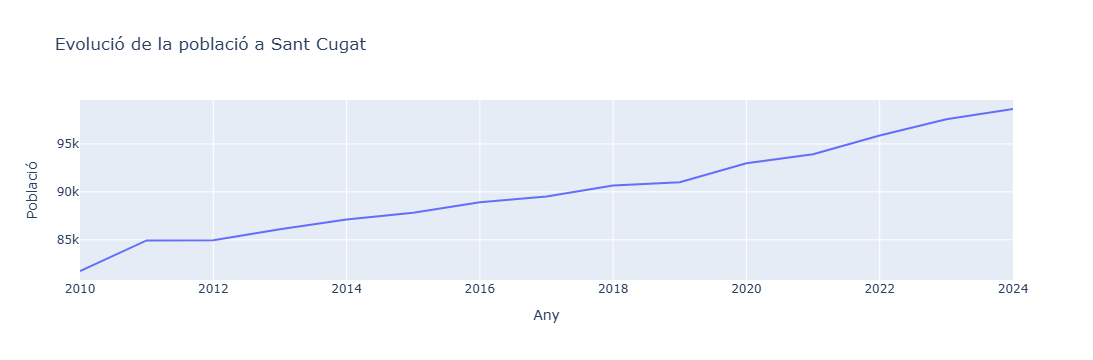

In [10]:
fig = px.line(df2, 
              y='Població',
              title=f'Evolució de la població a {ciutat}'
             )
fig.show()

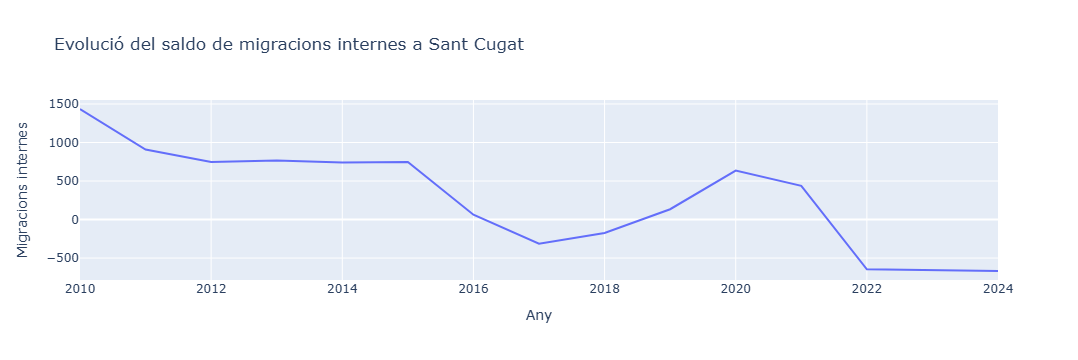

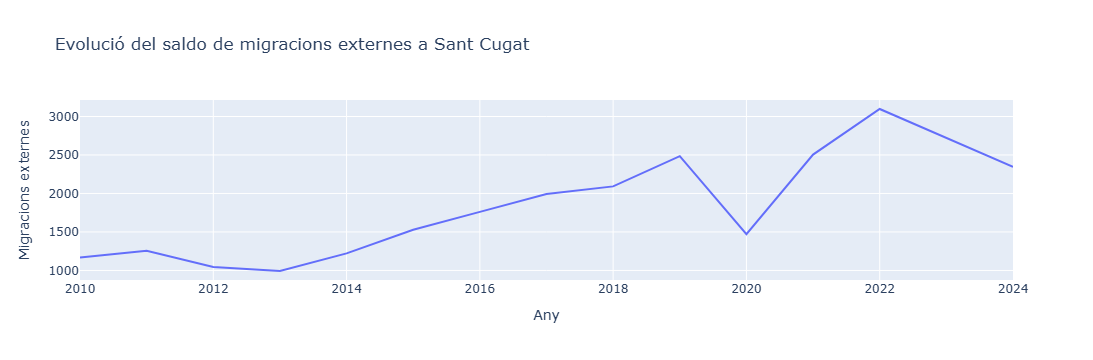

In [11]:
fig = px.line(df2, 
              y='Migracions internes',
              title=f'Evolució del saldo de migracions internes a {ciutat}'
             )
fig2 = px.line(df2,
               y='Migracions externes',
               title=f'Evolució del saldo de migracions externes a {ciutat}'
              )
fig.show()
fig2.show()

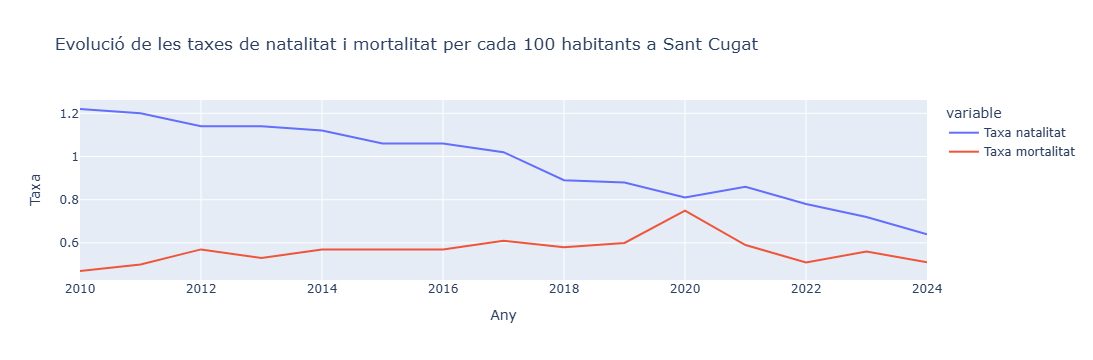

In [12]:
fig = px.line(df2, 
              y=['Taxa natalitat', 'Taxa mortalitat'],
              title=f'Evolució de les taxes de natalitat i mortalitat per cada 100 habitants a {ciutat}',
              labels={'value':'Taxa'}
             )
fig.show()

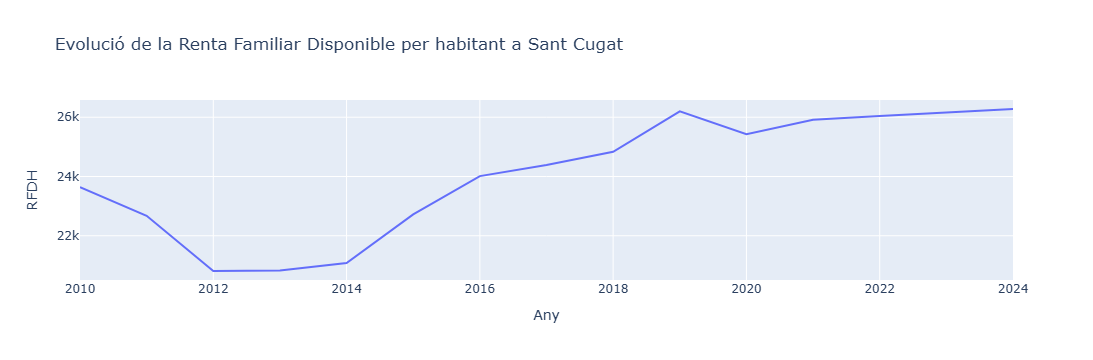

In [13]:
fig = px.line(df2, 
              y='RFDH',
              title=f'Evolució de la Renta Familiar Disponible per habitant a {ciutat}'
             )
fig.show()

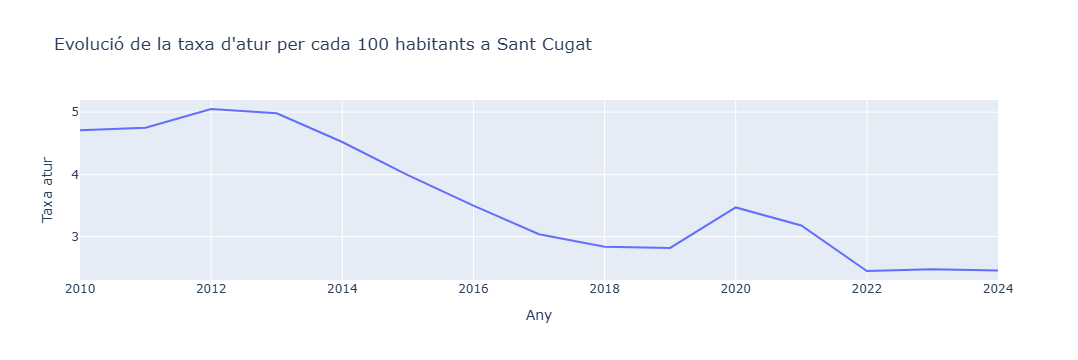

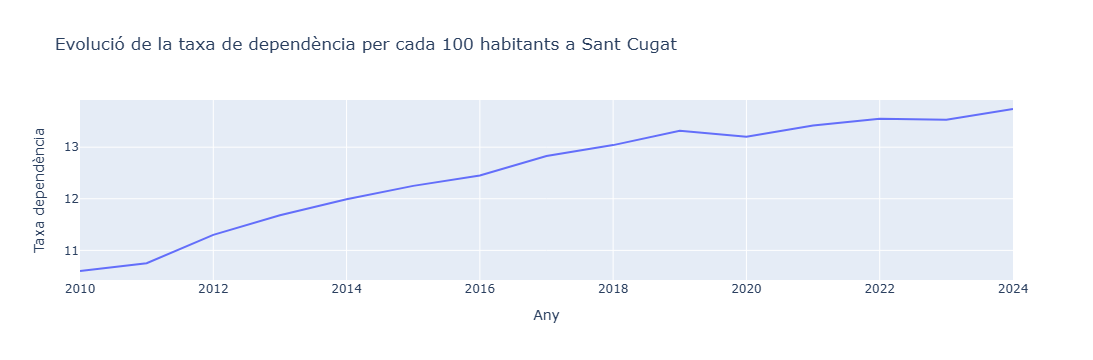

In [14]:
fig = px.line(df2, y='Taxa atur',
              title=f"Evolució de la taxa d'atur per cada 100 habitants a {ciutat}",
              labels={'value':"Taxa d'atur"}
             )
fig2 = px.line(df2, y='Taxa dependència',
               title=f"Evolució de la taxa de dependència per cada 100 habitants a {ciutat}",
               labels={'value':"Taxa de dependència"}
              )
fig.show()
fig2.show()

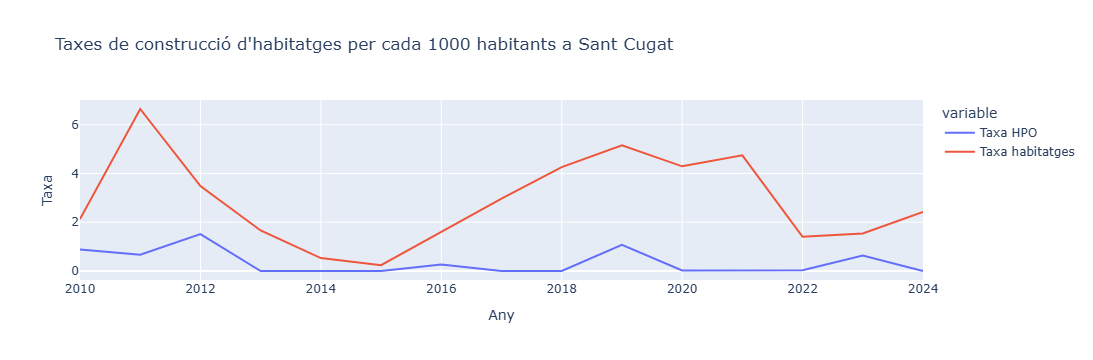

In [15]:
fig = px.line(df2,
              y=['Taxa HPO', 'Taxa habitatges'],
              title=f"Taxes de construcció d'habitatges per cada 1000 habitants a {ciutat}",
              labels={'value':'Taxa'}
             )
fig.show()

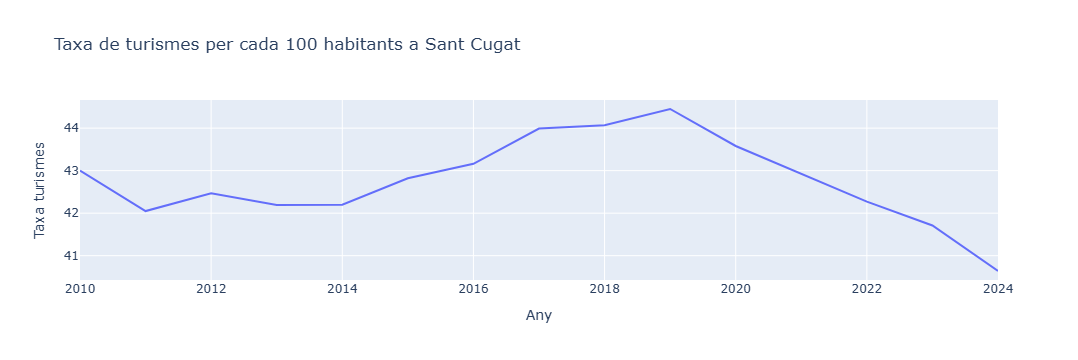

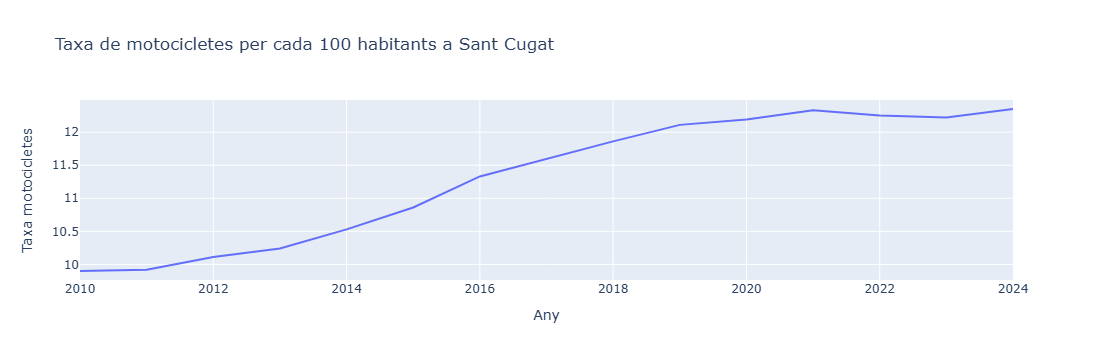

In [16]:
fig = px.line(df2, 
              y='Taxa turismes',
              title=f'Taxa de turismes per cada 100 habitants a {ciutat}'
             )
fig2 = px.line(df2, 
               y='Taxa motocicletes',
               title=f'Taxa de motocicletes per cada 100 habitants a {ciutat}'
              )
fig.show()
fig2.show()

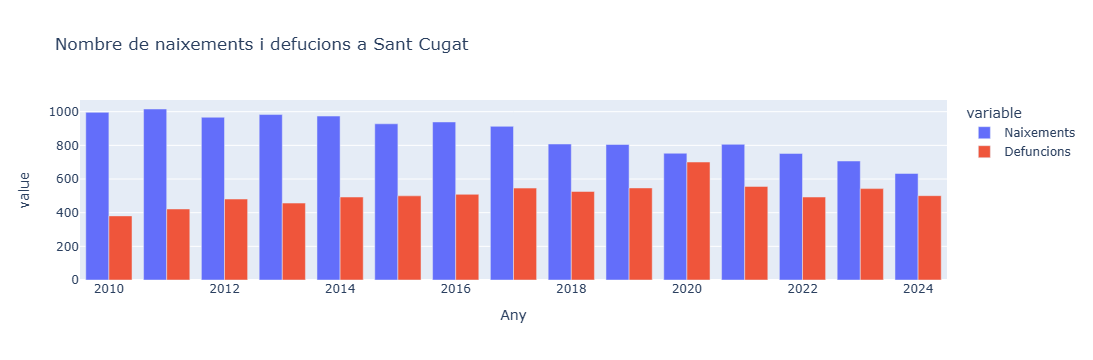

In [17]:
fig = px.bar(df2,
             y= ['Naixements', 'Defuncions'],
             barmode='group',
             title=f'Nombre de naixements i defucions a {ciutat}'
            )
fig.show()

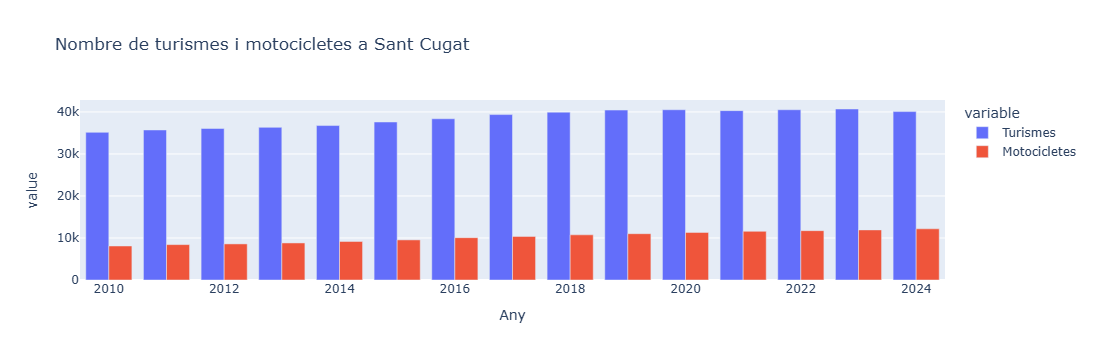

In [18]:
fig = px.bar(df2,
             y= ['Turismes', 'Motocicletes'],
             barmode='group',
             title=f'Nombre de turismes i motocicletes a {ciutat}'
            )
fig.show()

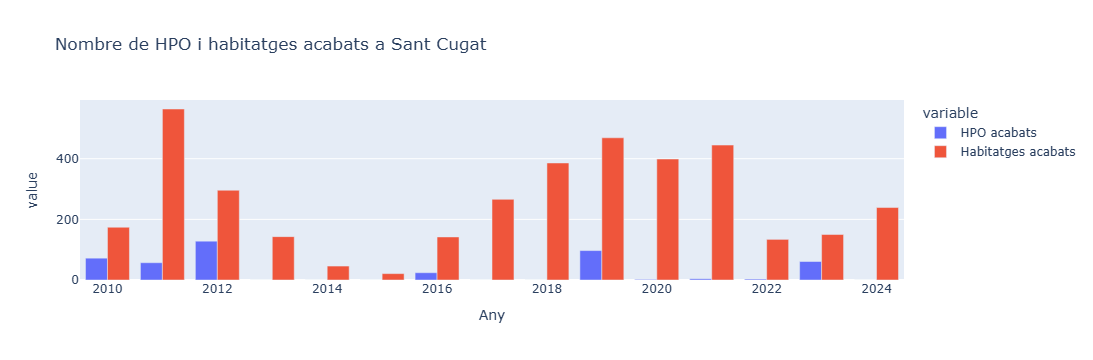

In [19]:
fig = px.bar(df2,
             y= ['HPO acabats', 'Habitatges acabats'],
             barmode='group',
             title=f"Nombre de HPO i habitatges acabats a {ciutat}"
            )
fig.show()

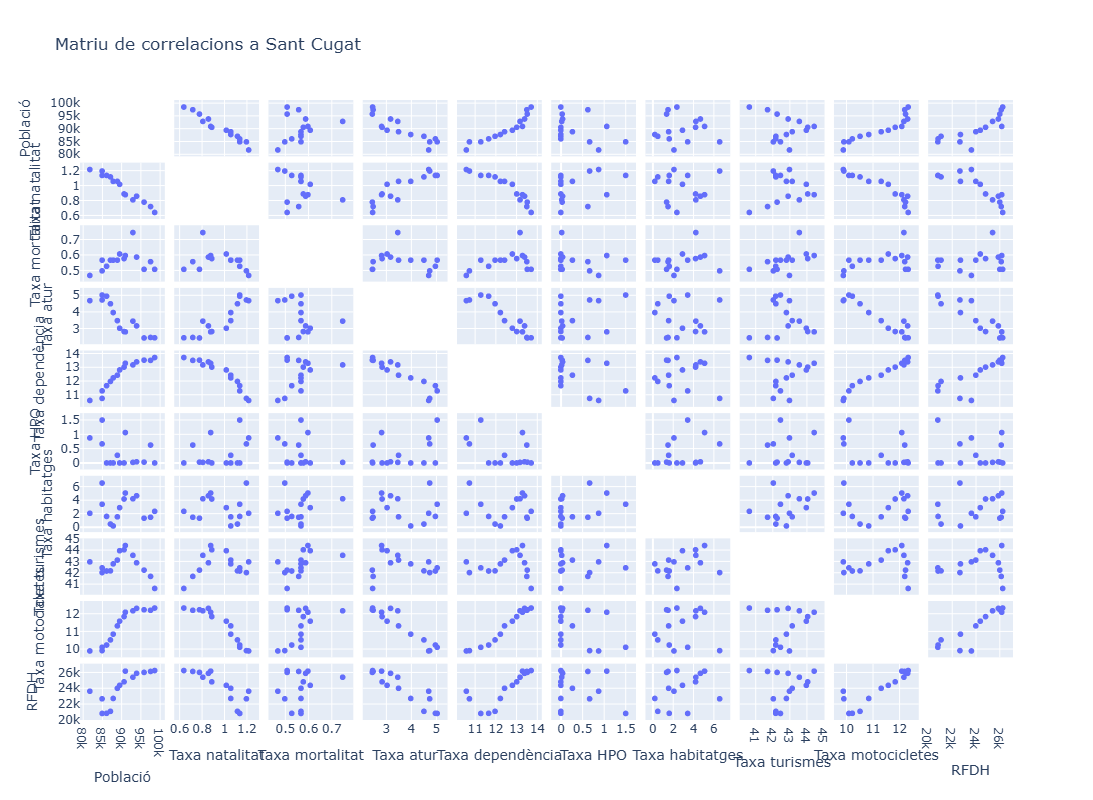

In [20]:
fig = px.scatter_matrix(
    df2,
    dimensions = ['Població', 'Taxa natalitat', 'Taxa mortalitat', 'Taxa atur', 'Taxa dependència',
                  'Taxa HPO', 'Taxa habitatges', 'Taxa turismes', 'Taxa motocicletes', 'RFDH'],
    height=800,
    width=800,
    title=f'Matriu de correlacions a {ciutat}'
)
fig.update_traces(diagonal_visible=False)  # Ocultar histogramas en la diagonal
fig.update_layout(
    dragmode='select',     # Permitir selección de puntos
    hovermode='closest',   # Mostrar datos al pasar el ratón
    font=dict(size=12)
)
fig.show()

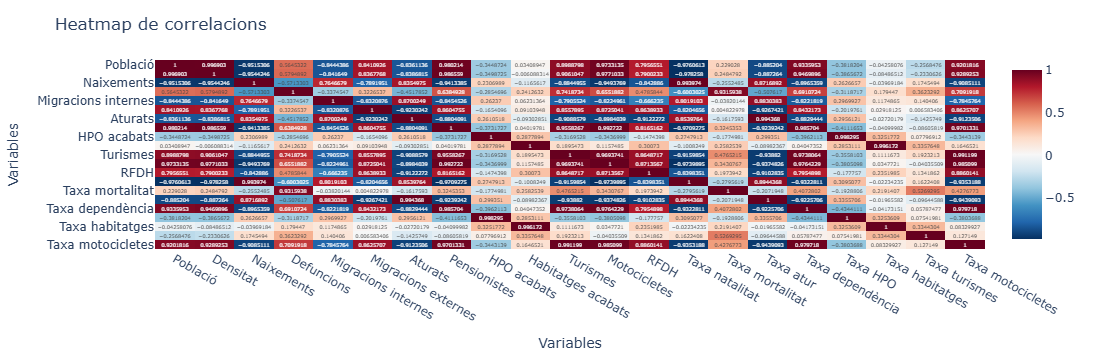

In [21]:
corr = df2.corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

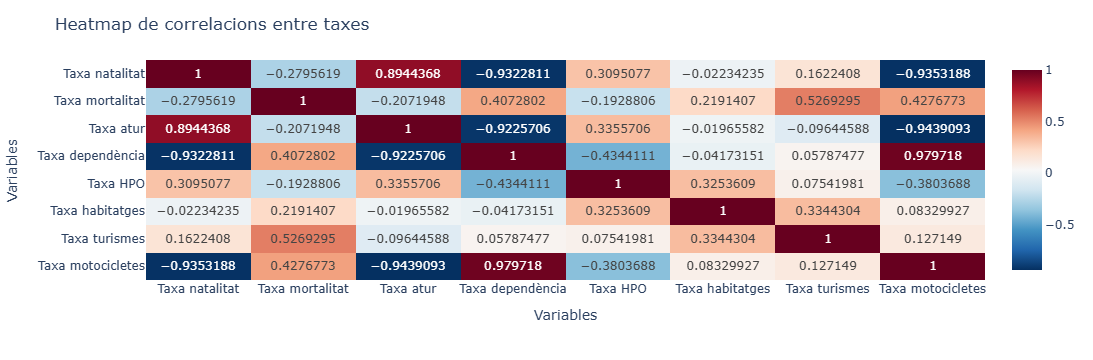

In [22]:
cols = [c for c in df.columns if 'Taxa' in c]
corr = df2[cols].corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions entre taxes', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

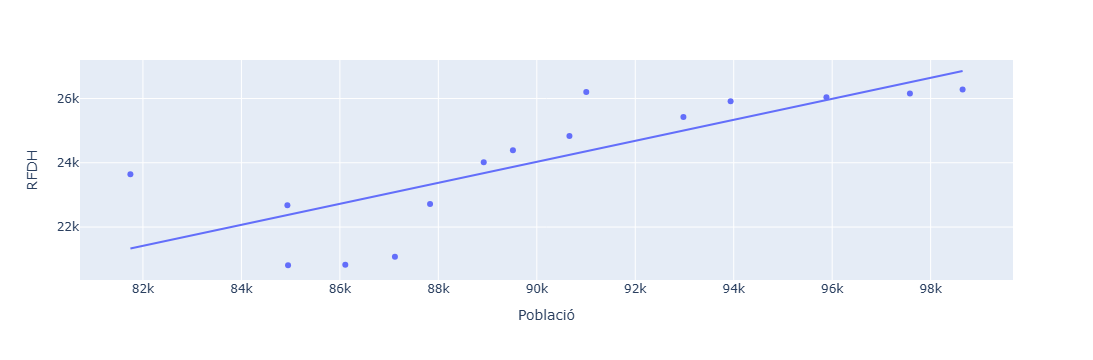

In [23]:
fig = px.scatter(df2, x='Població', y='RFDH', trendline='ols')
fig.show()

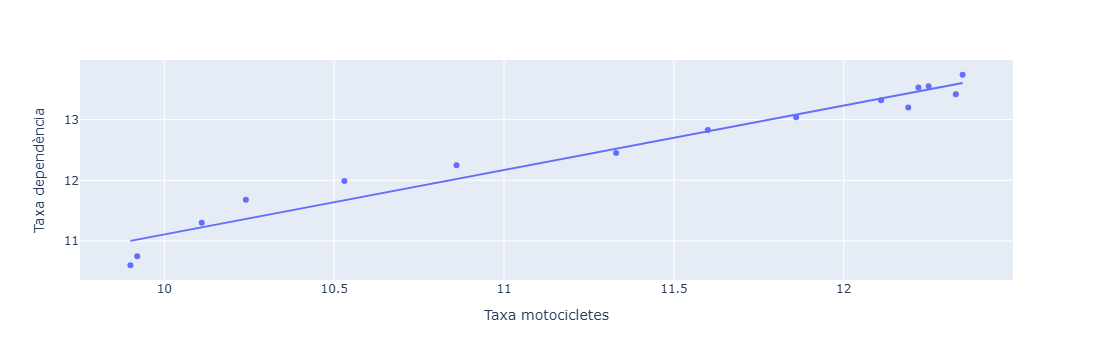

In [24]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa dependència', trendline='ols')
fig.show()

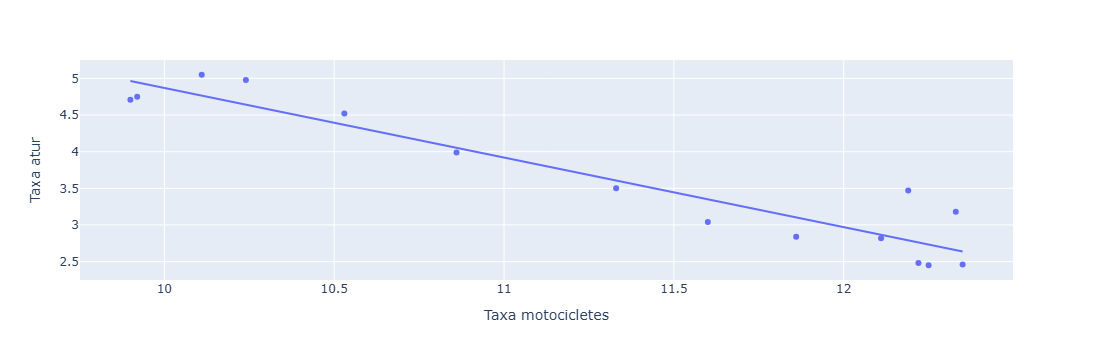

In [25]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa atur', trendline='ols')
fig.show()

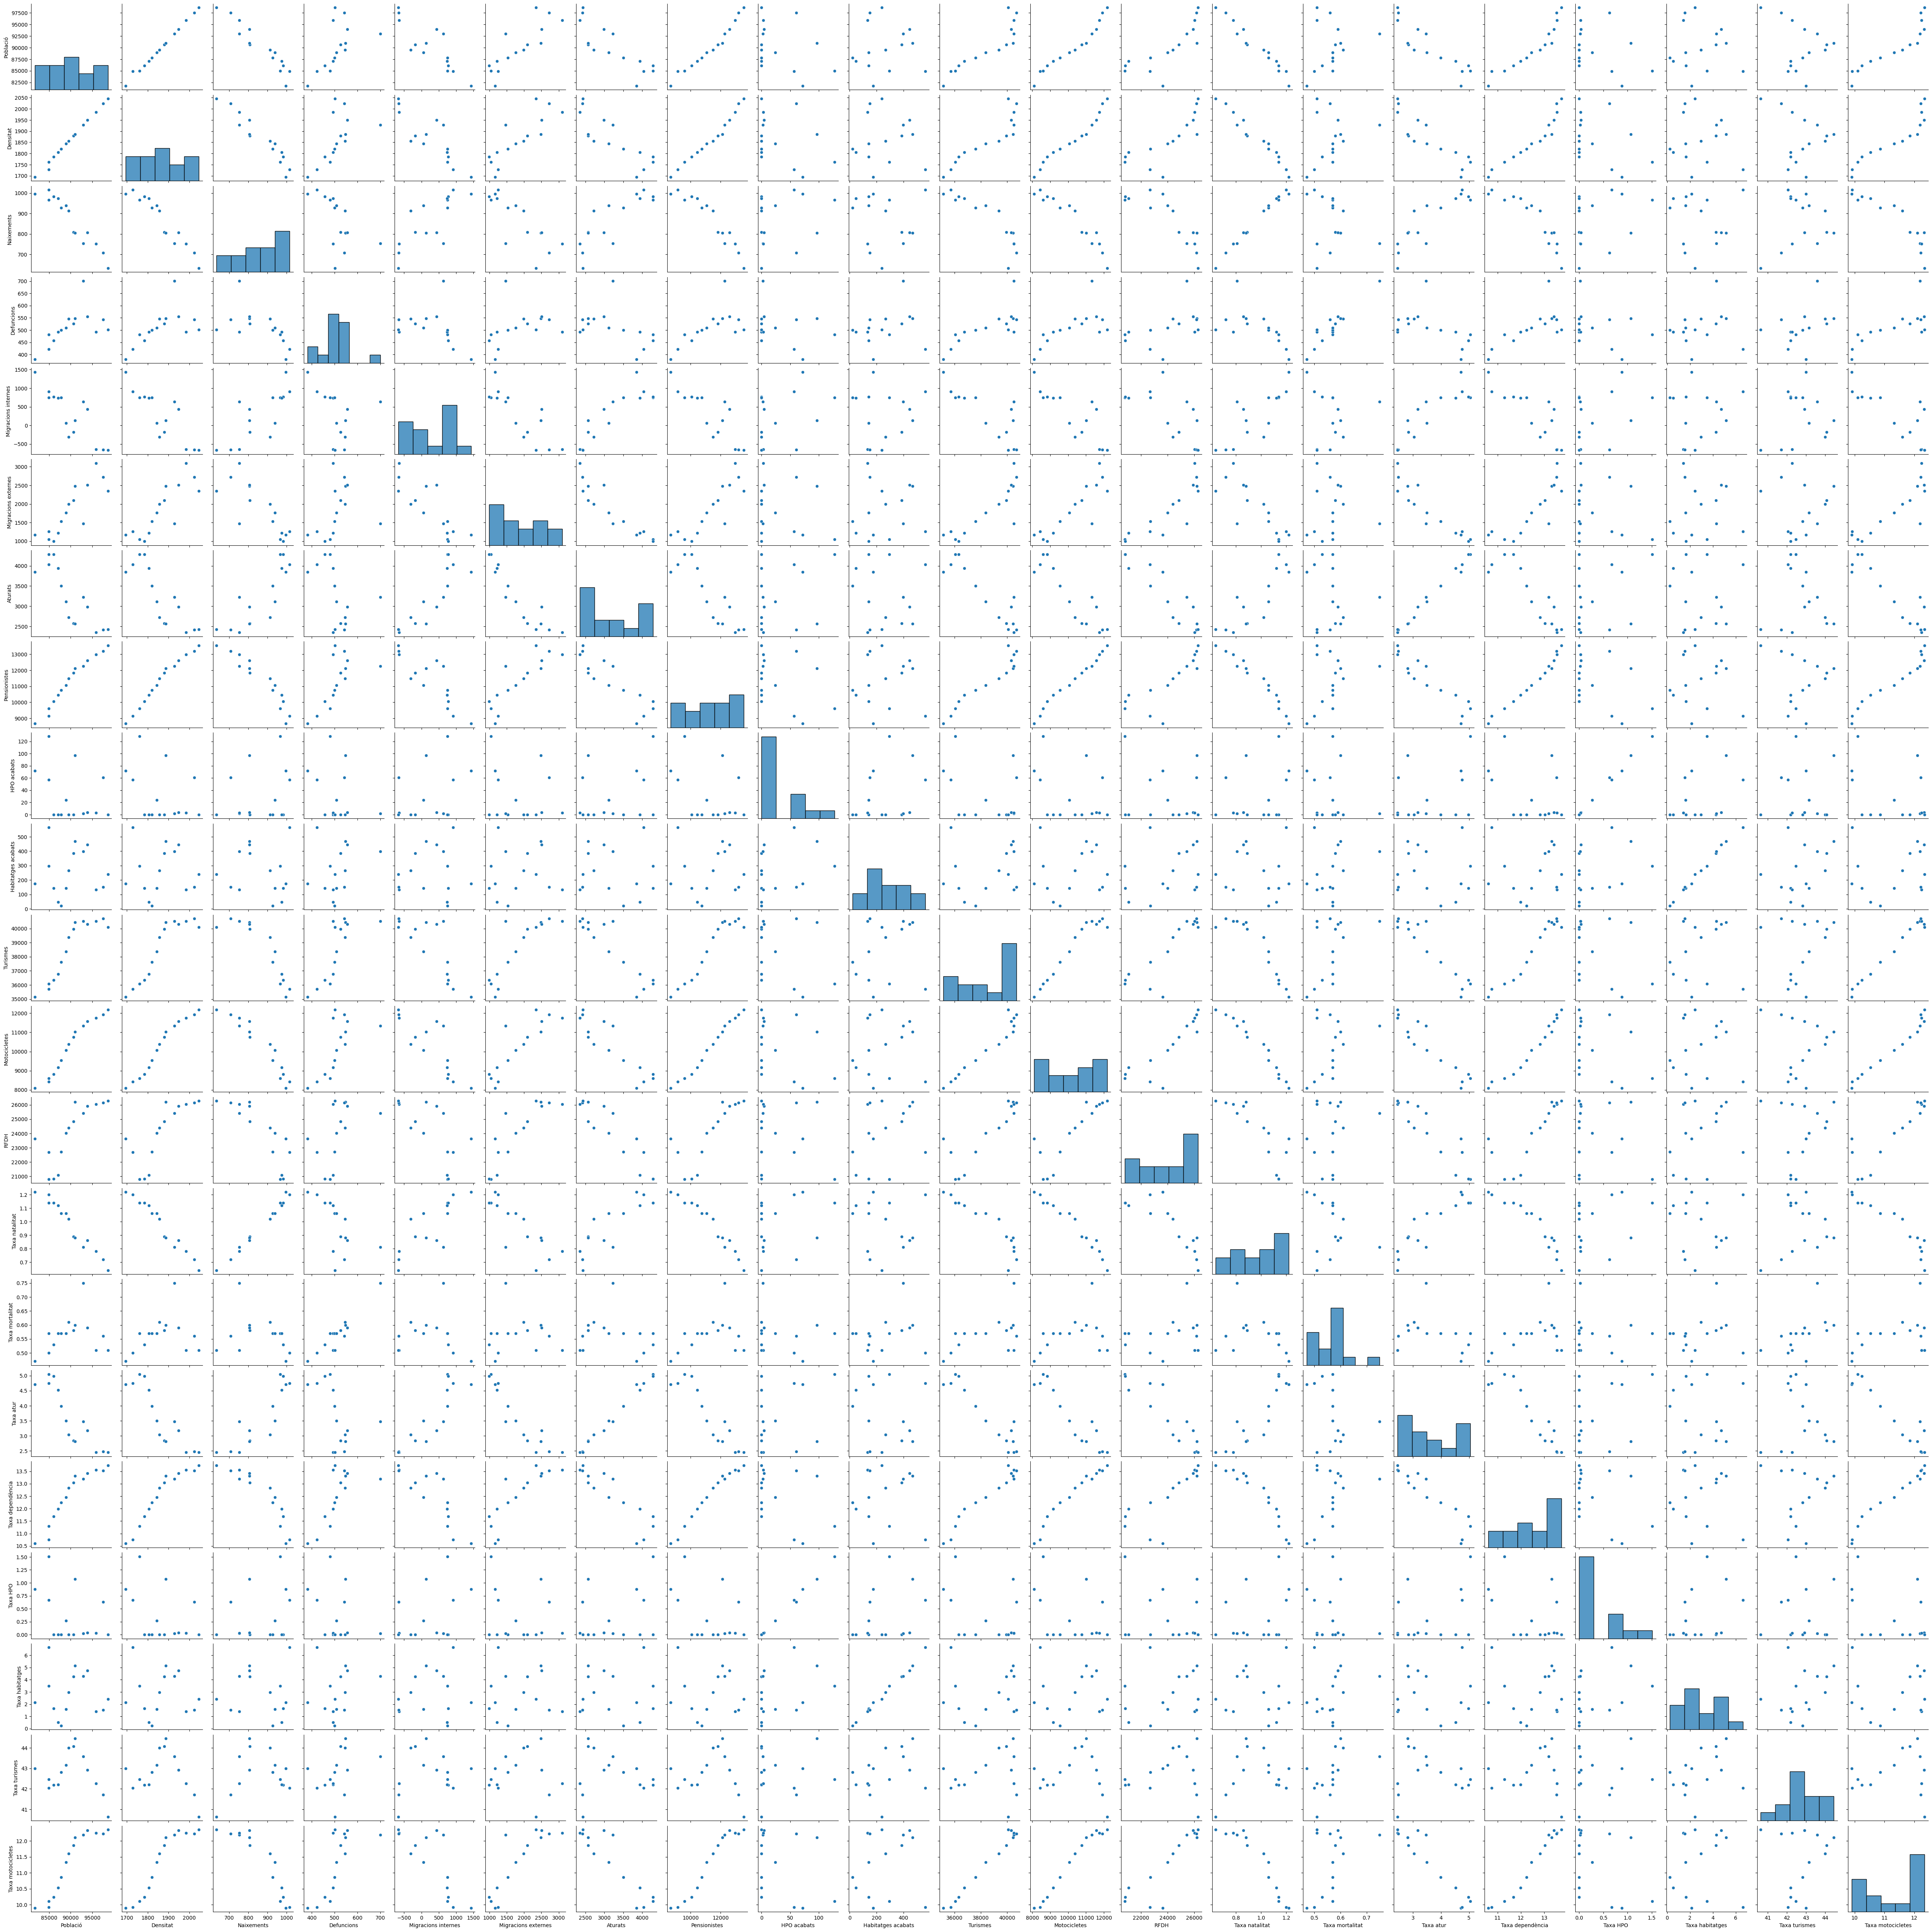

In [26]:
sns.pairplot(df2)
plt.show()

**ANÀLISI PREDICTIU**

              Variable  Coeficient
0           Naixements  -25.510762
1           Defuncions    6.209021
2  Migracions internes   -1.744083
3  Migracions externes    0.948427
[107760.36210725]
r2 = 0.9460016027531274


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_7648\113110075.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



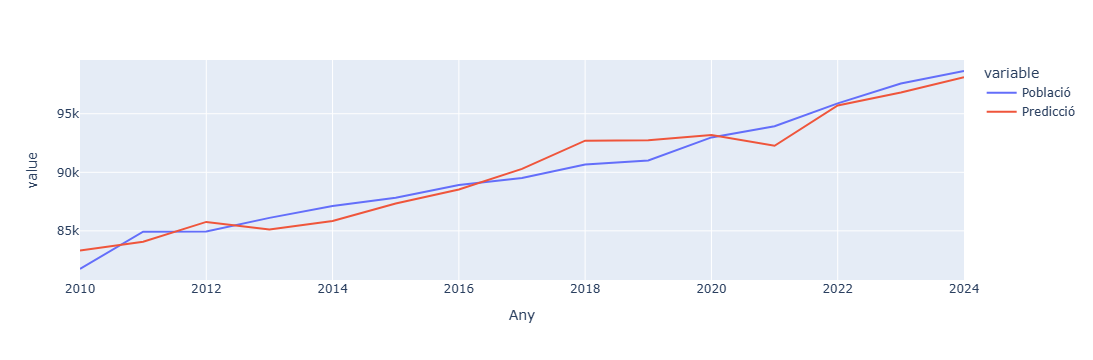

In [27]:
# Predicció de Població segons Naixements, Defuncions i Migracions

X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()


In [28]:
# Predicció de Població segons Naixements, Defuncions i Migracions amb Random Forest

# 1. Seleccionar variables
X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2["Població"]

# 2. Dividir en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Crear i entrenar el model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

# 4. Avaluació
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

# 5. Importància de les variables
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


RMSE: 2559.6621269862912
R2: 0.7573272432754188
Naixements             0.604019
Migracions internes    0.167623
Migracions externes    0.144150
Defuncions             0.084208
dtype: float64


              Variable  Coeficient
0           Naixements   -5.585366
1           Defuncions   -5.871306
2              Aturats    4.269801
3         Pensionistes    3.002130
4                 RFDH    0.802170
5  Migracions internes   -2.353208
6  Migracions externes   -0.080495
[31718.87638984]
r2 = 0.9898750001981879


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_7648\1570774157.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



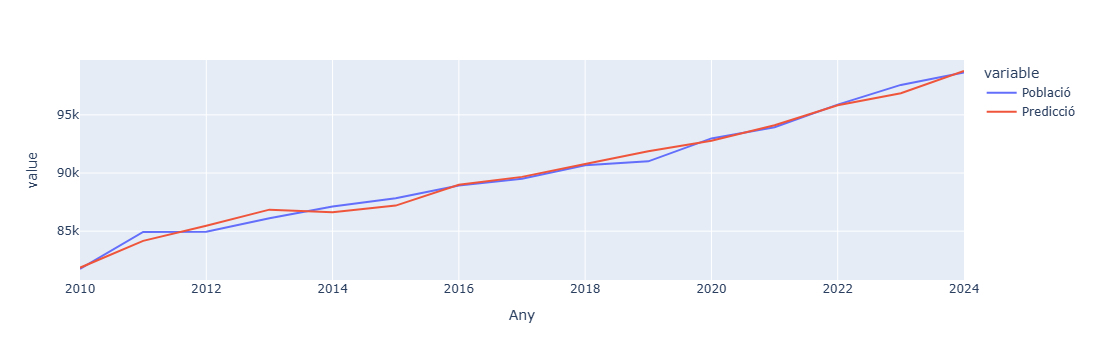

In [29]:
# Predicció de Població segons Naixements, Defuncions, Aturats, Pensionistes, RFDH i Migracions

X = df2[["Naixements", "Defuncions", "Aturats", "Pensionistes", "RFDH", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

              Variable  Coeficient
0             Població    0.136769
1                 RFDH   -0.200798
2           Naixements    0.287268
3           Defuncions    0.634394
4  Migracions internes    0.534774
5  Migracions externes   -0.023965
6         Pensionistes   -0.422221
[-170.92518056]
r2 = 0.9843861358614241


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_7648\2175888387.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



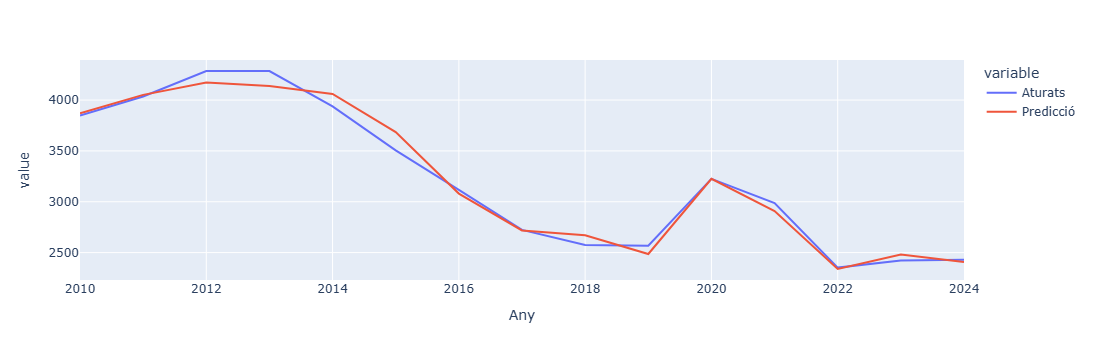

In [30]:
# Predicció del nombre d'Aturats segons Població, RFDH, Naixements, Defuncions i Migracions

X = df2[["Població", "RFDH", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Pensionistes"]]
y = df2[["Aturats"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Aturats']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()



              Variable  Coeficient
0             Població    0.445821
1           Naixements   -3.742745
2           Defuncions    4.648364
3  Migracions internes    1.985018
4  Migracions externes    0.820551
5              Aturats   -3.483959
6         Pensionistes   -1.771602
[13960.37425873]
r2 = 0.9666672158739983


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_7648\791505936.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



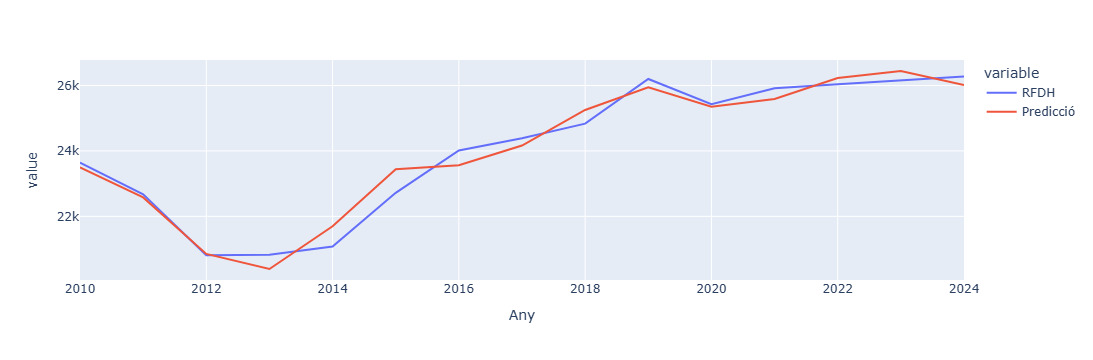

In [31]:
# Predicció del nombre de RFDH segons Població, Naixements, Defuncions, Migracions, Aturats i Pensionistes

X = df2[["Població", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Aturats", "Pensionistes"]]
y = df2[["RFDH"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['RFDH']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

                               SARIMAX Results                                
Dep. Variable:               Població   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -113.078
Date:                Thu, 05 Feb 2026   AIC                            232.156
Time:                        10:25:45   BIC                            234.073
Sample:                    01-01-2010   HQIC                           231.978
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.017     58.354      0.000       0.966       1.034
ma.L1         -0.9985      0.445     -2.242      0.025      -1.871      -0.126
sigma2      5.985e+05   7.68e-07   7.79e+11      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



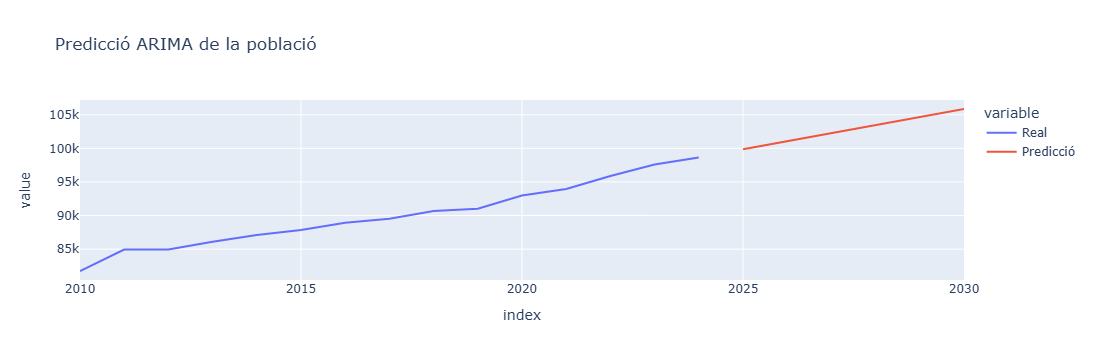

In [32]:
# Prediccions de Població al futur amb ARIMA

s = df2["Població"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de la població")
fig.show()



                               SARIMAX Results                                
Dep. Variable:                   RFDH   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -114.730
Date:                Thu, 05 Feb 2026   AIC                            235.460
Time:                        10:25:49   BIC                            237.377
Sample:                    01-01-2010   HQIC                           235.282
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3827      1.935      0.198      0.843      -3.410       4.176
ma.L1         -0.4757      1.609     -0.296      0.767      -3.629       2.677
sigma2      8.095e+05   3.47e+05      2.330      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



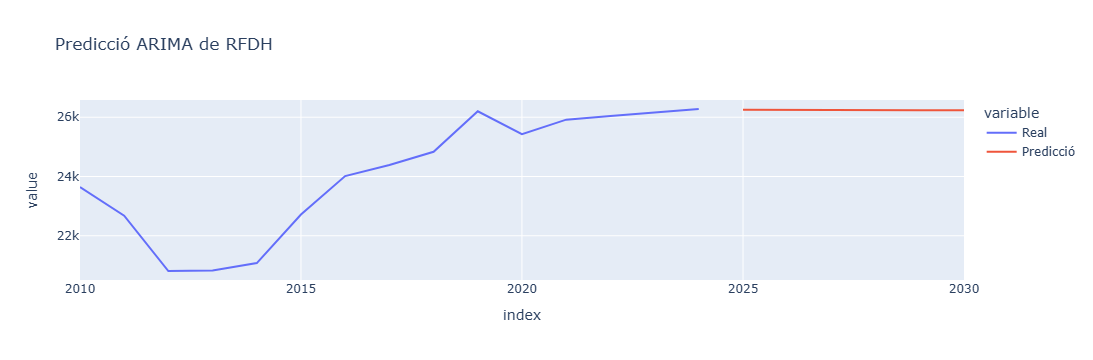

In [33]:
# Prediccions de RFDH al futur amb ARIMA

s = df2["RFDH"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de RFDH")
fig.show()

                               SARIMAX Results                                
Dep. Variable:                Aturats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -100.021
Date:                Thu, 05 Feb 2026   AIC                            206.042
Time:                        10:25:50   BIC                            207.959
Sample:                    01-01-2010   HQIC                           205.864
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2272      0.695     -0.327      0.744      -1.590       1.136
ma.L1          0.6965      0.595      1.171      0.242      -0.469       1.862
sigma2      8.956e+04   3.91e+04      2.288      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



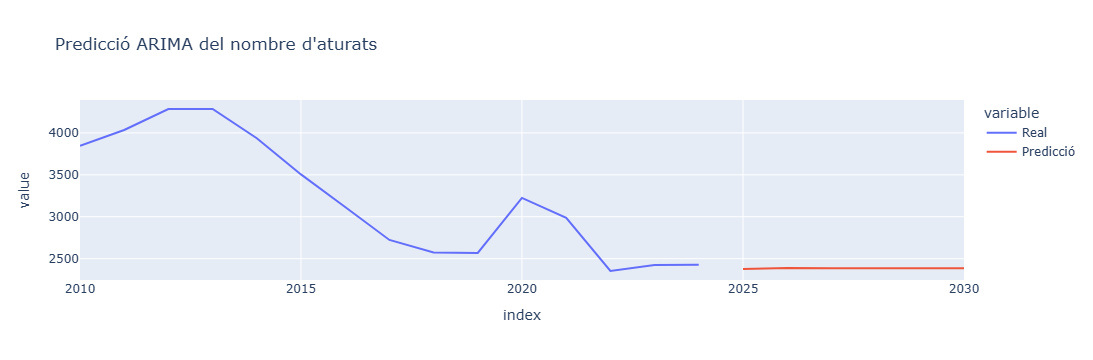

In [34]:
# Prediccions de Aturats al futur amb ARIMA

s = df2["Aturats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA del nombre d'aturats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:     Habitatges acabats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -90.667
Date:                Thu, 05 Feb 2026   AIC                            187.333
Time:                        10:25:51   BIC                            189.251
Sample:                    01-01-2010   HQIC                           187.156
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5021      0.572      0.878      0.380      -0.618       1.622
ma.L1         -0.9993     83.665     -0.012      0.990    -164.979     162.980
sigma2      2.183e+04   1.82e+06      0.012      0.9

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



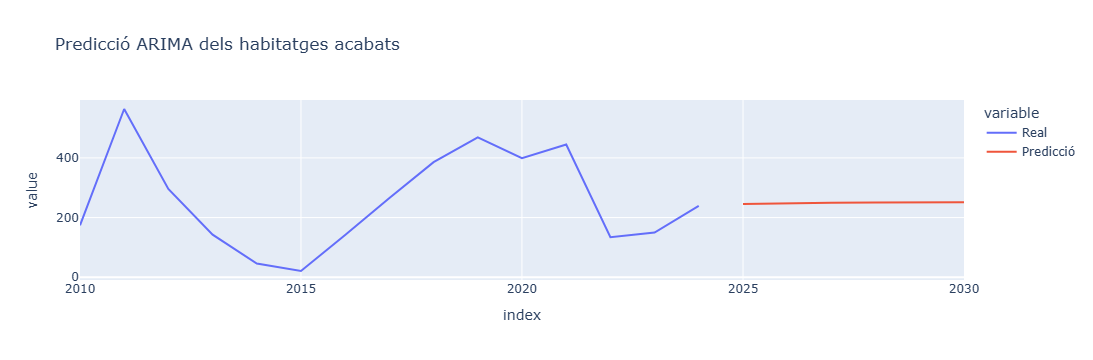

In [35]:
# Prediccions de Habitatges acabats al futur amb ARIMA

s = df2["Habitatges acabats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA dels habitatges acabats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Naixements   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -73.238
Date:                Thu, 05 Feb 2026   AIC                            152.476
Time:                        10:25:53   BIC                            154.394
Sample:                    01-01-2010   HQIC                           152.299
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.014     73.134      0.000       0.973       1.027
ma.L1         -0.9918      0.491     -2.021      0.043      -1.953      -0.030
sigma2      1831.4954      0.000   6.61e+06      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



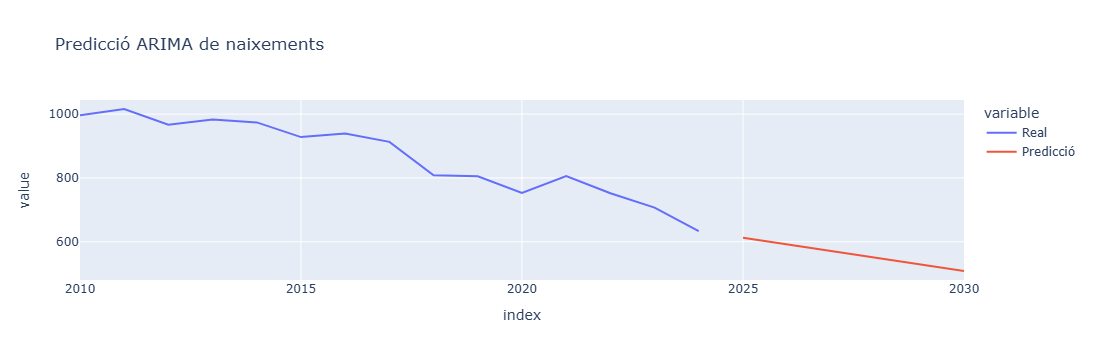

In [36]:
# Prediccions de Naixements acabats al futur amb ARIMA

s = df2["Naixements"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de naixements")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Defuncions   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -77.807
Date:                Thu, 05 Feb 2026   AIC                            161.614
Time:                        10:25:53   BIC                            163.531
Sample:                    01-01-2010   HQIC                           161.436
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1235      0.594      0.208      0.835      -1.041       1.288
ma.L1         -0.4989      0.549     -0.908      0.364      -1.576       0.578
sigma2      3879.7474   1220.203      3.180      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



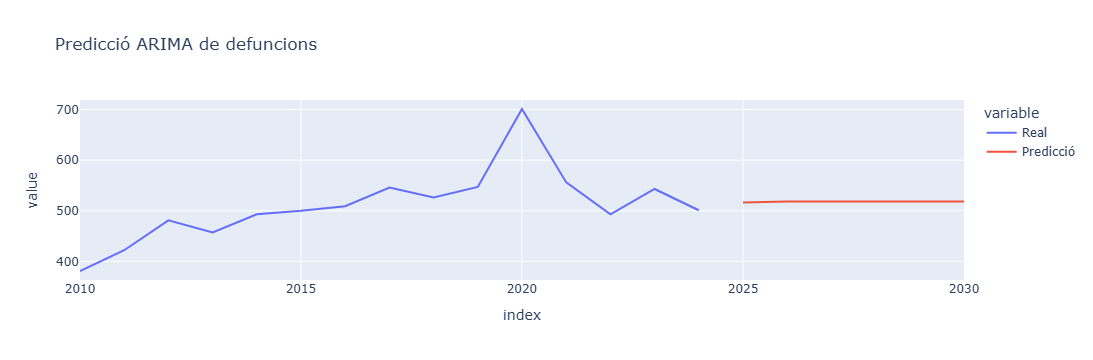

In [37]:
# Prediccions de Defuncions al futur amb ARIMA

s = df2["Defuncions"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de defuncions")
fig.show()